In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joypy

font = {'size'   : 14}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
set2_colors = plt.get_cmap("Set2").colors

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory (including wes, wgs, etc subfolders)
data_dir = ""

save_plots = False
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
filtered_maf_WGS = pd.read_csv(data_dir+"HTAN_WGS_filtered_ppVAFs.maf", sep="\t")
filtered_maf_WES = pd.read_csv(data_dir+"HTAN_WES_filtered_ppVAFs.maf", sep="\t")

WGS_samples = list(set(filtered_maf_WGS["Tumor_Sample_Barcode"]))
sample_to_stage = dict(zip(filtered_maf_WGS["Tumor_Sample_Barcode"], filtered_maf_WGS["Stage"]))
sample_to_stage.update(dict(zip(filtered_maf_WES["Tumor_Sample_Barcode"], filtered_maf_WES["Stage"])))

/share/software/user/open/py-jupyter/1.0.0_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (85,87,88,90) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def load_patient_driver_dists(patient, gene, all_samples):
    try:
        all_dists = pd.read_csv(data_dir+patient+"_"+gene+"_marginals_WGS.csv")
    except (FileNotFoundError, pd.errors.EmptyDataError):
        return None
    
    try:
        WES_dists = pd.read_csv(data_dir+patient+"_"+gene+"_marginals_WES.csv")
        cols_to_keep = filter(lambda x: x.split(".")[0] not in WGS_samples, WES_dists.columns)
        all_dists = pd.concat([all_dists, WES_dists[list(cols_to_keep)]], axis=1)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        pass
    
    samples = [x.split(".")[0] for x in all_dists.columns]
    driver_ids = list(set(filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"]==gene)]["Mut_ID"]).union(set(filtered_maf_WES[np.logical_and(filtered_maf_WES["Driver"], filtered_maf_WES["Hugo_Symbol"]==gene)]["Mut_ID"])))

    cols_to_keep = filter(lambda x: x.split(".")[1] in driver_ids, all_dists.columns)
    all_dists = all_dists[list(cols_to_keep)]

    cols_to_keep = list(filter(lambda x: x.split(".")[0] in all_samples, all_dists.columns))
    all_dists = all_dists[list(cols_to_keep)]
    samples = [x.split(".")[0] for x in all_dists.columns]
    if len(samples) == 0:
        return None
    max_muts = pd.value_counts(samples).iloc[0]
    new_df = np.zeros(shape=(1000 * len(all_samples), max_muts))
    new_df[:] = np.nan
    sample_to_idx = dict(zip(all_samples, range(len(all_samples))))
    for i, sample in enumerate(samples):
        num_prev_muts = 0
        try:
            sample_idx = sample_to_idx[sample]
        except KeyError:
            continue
        while not np.isnan(new_df[sample_idx*1000, num_prev_muts]):
            num_prev_muts += 1
        new_df[sample_idx*1000:(sample_idx+1)*1000, num_prev_muts] = all_dists[all_dists.columns[i]]
    to_return = pd.DataFrame(new_df, columns=[gene+"_"+str(i) for i in range(max_muts)])

    return to_return

def fixed_width_decimal_str(integer, num_chars):
    string = str(integer)
    assert len(string) <= num_chars
    return "0"*(num_chars-len(string)) + string

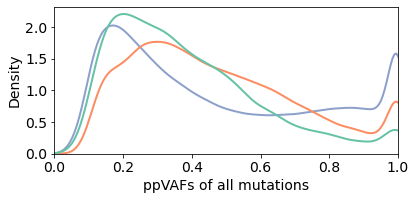

/tmp/ipykernel_168384/3127748134.py:14: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=to_plot, x="ppVAF", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)


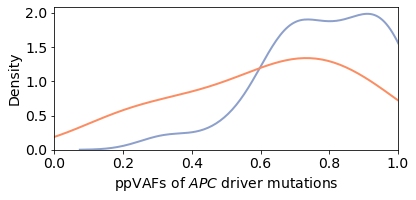

In [5]:
# FIGURE 1d (WGS only)

fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.kdeplot(data=filtered_maf_WGS, x="ppVAF", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)
plt.xlabel("ppVAFs of all mutations")
plt.xlim(0,1)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig1d_ppvaf_dists.pdf")
plt.show()

to_plot = filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"] == "APC")]
fig, ax = plt.subplots(1,1,figsize=(6,3))
sns.kdeplot(data=to_plot, x="ppVAF", hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", hue="Stage", ax=ax, common_norm=False, legend=False, linewidth=2)
plt.xlabel("ppVAFs of $APC$ driver mutations")
plt.xlim(0,1)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig1d_APC_dists.pdf")
plt.show()

In [6]:
# FIGURE 1f (WES and WGS)
patients = ["A001", "A002", "A014", "A015", "F001", "G001"]

only_APC = filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"] == "APC")]
only_APC_WES = filtered_maf_WES[np.logical_and(filtered_maf_WES["Driver"], filtered_maf_WES["Hugo_Symbol"] == "APC")]
only_APC_WES = only_APC_WES[~np.isin(only_APC_WES["Tumor_Sample_Barcode"], WGS_samples)]
only_APC = pd.concat([only_APC, only_APC_WES], axis=0)
only_APC = only_APC[np.isin(only_APC["Stage"], ["Benign", "Dysplasia"])]
multi_APC = only_APC.value_counts("Tumor_Sample_Barcode")
multi_APC = multi_APC[multi_APC > 1].index
only_APC = only_APC.sort_values("ppVAF", ascending=True).drop_duplicates(subset="Tumor_Sample_Barcode", keep="last")
sample_to_order = dict(zip(only_APC["Tumor_Sample_Barcode"], [fixed_width_decimal_str(i, 3) for i in range(len(only_APC))]))
order_to_sample = dict(zip([fixed_width_decimal_str(i, 3) for i in range(len(only_APC))], only_APC["Tumor_Sample_Barcode"]))

all_patient_data = []
for patient in patients:
    print(patient)
    all_samplenames = only_APC[only_APC["Patient"]==patient]["Tumor_Sample_Barcode"]
    all_samplenames = list(set(all_samplenames))
    APC_dists = load_patient_driver_dists(patient, "APC", all_samplenames)
    KRAS_dists = load_patient_driver_dists(patient, "KRAS", all_samplenames)
    all_dists = pd.concat([APC_dists, KRAS_dists], axis=1)
    sample_labels = [sample_to_order[x] for x in all_samplenames]
    all_dists["grouping"] = np.repeat(sample_labels, 1000)
    
    for_dropping = all_dists.columns.tolist()
    for_dropping.remove("grouping")
    all_dists.dropna(axis=0, how="all", inplace=True, subset=for_dropping)
    print(len(set(all_dists["grouping"])))
    all_patient_data.append(all_dists)
    
all_patient_data = pd.concat(all_patient_data, axis=0)
all_patient_data = all_patient_data.iloc[:, ::-1]

A001
6
A002
12
A014
1
A015
1
F001
29
G001
27


/oak/stanford/groups/ccurtis2/users/debra/py39_sherlock/lib/python3.9/site-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


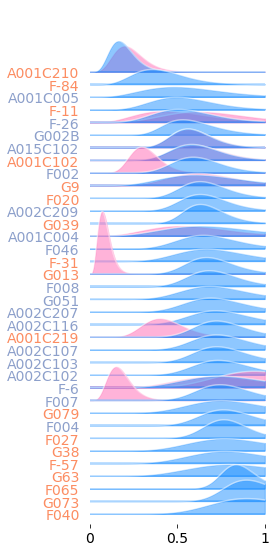

/oak/stanford/groups/ccurtis2/users/debra/py39_sherlock/lib/python3.9/site-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


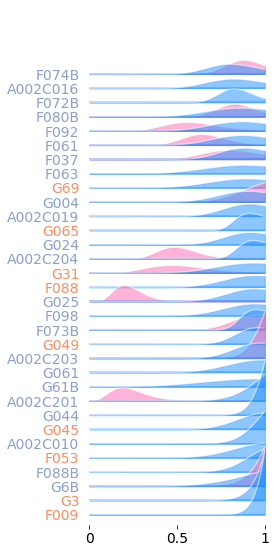

/oak/stanford/groups/ccurtis2/users/debra/py39_sherlock/lib/python3.9/site-packages/joypy/joyplot.py:238: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


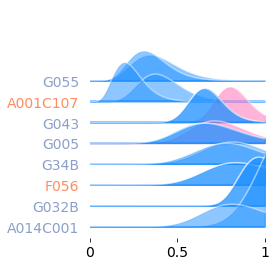

In [7]:
single_APC = only_APC[~np.isin(only_APC["Tumor_Sample_Barcode"], multi_APC)]
single_APC_subclonal = single_APC[~single_APC["final_clonal"]]["Tumor_Sample_Barcode"]
single_APC_clonal = single_APC[single_APC["final_clonal"]]["Tumor_Sample_Barcode"]

stage_colors = {"Benign":set2_colors[1], "Dysplasia":set2_colors[2]}

def plot_joyplots(samples_to_plot, fig_size, save_loc):
    sample_labels = sorted(samples_to_plot, key=lambda x: sample_to_order[x])
    sample_colors = [stage_colors[sample_to_stage[x]] for x in sample_labels]
    fig, axes = joypy.joyplot(all_patient_data[np.isin(all_patient_data["grouping"], [sample_to_order[x] for x in samples_to_plot])], by="grouping", figsize=fig_size, labels=sample_labels, x_range=[0,1000], kind = "values", color=["hotpink", "hotpink", "dodgerblue", "dodgerblue"], alpha=0.5, linecolor="white")
    axes[-1].set_xticks([0, 500, 1000])
    axes[-1].set_xticklabels([0, 0.5, 1])

    for i,color in enumerate(sample_colors):
        axes[i].tick_params(axis='y', colors=color)
    #plt.tight_layout()
    if save_plots:
        plt.savefig(save_loc)
    plt.show()
    
plot_joyplots(single_APC_subclonal, (4,8), plots_dir+"Fig1f_subclonalAPC.pdf")
plot_joyplots(single_APC_clonal, (4,8), plots_dir+"Fig1f_clonalAPC.pdf")
plot_joyplots(multi_APC, (4,4), plots_dir+"Fig1f_multiAPC.pdf")

APC


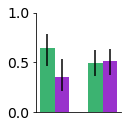

KRAS


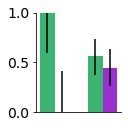

FBXW7


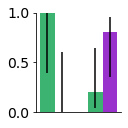

In [8]:
# FIGURE 1g (WES and WGS)
drivers_to_plot = ["APC", "KRAS", "FBXW7"]

clonal_color = "darkorchid"
subclonal_color = "mediumseagreen"
color_array = [subclonal_color, clonal_color, subclonal_color, clonal_color]

dodge = 0.15
to_plot_x = [0 - dodge, 0 + dodge, 1 - dodge, 1 + dodge]
for driver in drivers_to_plot:
    only_driver = filtered_maf_WGS[np.logical_and(filtered_maf_WGS["Driver"], filtered_maf_WGS["Hugo_Symbol"] == driver)]
    only_driver_WES = filtered_maf_WES[np.logical_and(filtered_maf_WES["Driver"], filtered_maf_WES["Hugo_Symbol"] == driver)]
    only_driver_WES = only_driver_WES[~np.isin(only_driver_WES["Tumor_Sample_Barcode"], WGS_samples)]
    only_driver = pd.concat([only_driver, only_driver_WES], axis=0)
    only_driver["isclonal_CI"] = only_driver["ppVAF_upper"] == 1
    only_benign = only_driver[only_driver["Stage"]=="Benign"]
    only_dysplasia = only_driver[only_driver["Stage"]=="Dysplasia"]
    
    benign_subclonal = np.sum(~only_benign["final_clonal"])
    benign_clonal = np.sum(only_benign["final_clonal"])
    dysplasia_subclonal = np.sum(~only_dysplasia["final_clonal"])
    dysplasia_clonal = np.sum(only_dysplasia["final_clonal"])
    
    to_plot_y = np.array([benign_subclonal/(benign_subclonal+benign_clonal), benign_clonal/(benign_subclonal+benign_clonal), dysplasia_subclonal/(dysplasia_subclonal+dysplasia_clonal), dysplasia_clonal/(dysplasia_subclonal+dysplasia_clonal)])
    to_plot_errors = np.transpose(np.array([compute_binomial_bayes_CI(benign_subclonal, benign_clonal), compute_binomial_bayes_CI(benign_clonal, benign_subclonal), compute_binomial_bayes_CI(dysplasia_subclonal, dysplasia_clonal), compute_binomial_bayes_CI(dysplasia_clonal, dysplasia_subclonal)]))
    to_plot_errors[0,:] = to_plot_y - to_plot_errors[0,:]
    to_plot_errors[1,:] = to_plot_errors[1,:] - to_plot_y
    
    print(driver)
    
    fig, ax = plt.subplots(1,1,figsize=(2,2))
    plt.bar(x=to_plot_x, height=to_plot_y, yerr=to_plot_errors, color=color_array, width=dodge*2)
    plt.xlabel("")
    plt.xticks([])
    plt.ylim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if save_plots:
        plt.savefig(plots_dir+"Fig1g_"+driver+"_clonal_class_bar.pdf")
    plt.show()
